# Introduction

This notebook demonstrates the use of the Google Vertex AI Python Client to build and deploy an AutoML model.

## Setup

In [1]:
! pip3 install --upgrade --quiet google-cloud-aiplatform

In [2]:
!pip install gdown

inputs:

In [86]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
REGION = 'us-central1'
print(f'project id: {PROJECT_ID}')

project id: auto-ml-433608


In [87]:
DATANAME = 'churn'

In [88]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = DATANAME
BQ_TABLE = 'churn_tbl'

In [5]:
SOURCE_FILE_NAME = 'churn_data.csv'

In [89]:
VAR_TARGET = 'Exited'

packages:

In [155]:
from google.cloud import aiplatform
from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import gdown
import os

clients:

In [91]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client(project = PROJECT_ID)

resources:

In [56]:
DEPLOY_COMPUTE = 'n1-standard-2'

# Download the data & load to BigQuery

Download the csv file:

In [10]:
# gdown.download(f"https://drive.google.com/uc?export=download&id=1l6PZwNBIJ4urIRduH32gSa7fa_LO_KTp", SOURCE_FILE_NAME, quiet=False)

create empty BigQuery dataset. In BigQuery, tables must reside within a dataset.
A dataset is essentially a container for tables, and it provides organizational structure and access control to the tables. 

In [30]:
ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
ds.location = REGION
ds = bq.create_dataset(dataset = ds, exists_ok = True)

Load the data from the csv file into the BigQuery dataset:

In [31]:
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True # Let BigQuery autodetect the schema
)

with open(SOURCE_FILE_NAME, "rb") as source_file:
    load_job = bq.load_table_from_file(
        source_file,
        ds.table(BQ_TABLE),
        job_config=job_config,
    )

load_job.result()

print(f"Loaded {load_job.output_rows} rows into {BQ_DATASET}.{BQ_TABLE}.")

Loaded 10000 rows into churn.churn_tbl.


Transform column names with whitespaces to column names with underscores (AutoML prohibits column names with whitespace)

In [92]:
table_ref = f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}"
table = bq.get_table(table_ref)
columns = [schema.name for schema in table.schema]
cleaned_columns = [f"`{col}` AS `{col.replace(' ', '_')}`" for col in columns]

In [33]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
SELECT
  {', '.join(cleaned_columns)}
FROM
  `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`;
"""
job = bq.query(query=query)
job.result()

print(f"Columns cleaned in place and table `{BQ_TABLE}` updated in `{BQ_DATASET}` dataset.")

Columns cleaned in place and table `churn_tbl` updated in `churn` dataset.


Remove the csv file as it is no longer needed:

In [15]:
# os.remove(SOURCE_FILE_NAME)

Display target class imbalance:

In [16]:
query = f"""
SELECT {VAR_TARGET}
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
df = bq.query(query = query).to_dataframe()

In [17]:
df[VAR_TARGET].value_counts()

Exited
0    7962
1    2038
Name: count, dtype: Int64

Prepare data for analysis - split into train, validation, and test sets while maintaining the proportions of the target class in each set

In [38]:
table = bq.get_table(table_ref)
columns = [field.name for field in table.schema]

query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
WITH class_counts AS (
  /*
  This Common Table Expression (CTE) calculates the total number of records for each value of the target (Exited) column
  */
  SELECT 
    {VAR_TARGET},
    COUNT(*) as total_count
  FROM 
    `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
  GROUP BY 
    {VAR_TARGET}
),
stratified_data AS (
  /*
   This CTE assigns a row number (stratified_row_num) to each record within each target class (exited),
   ensuring that the row numbers are ordered within each class.
   It also joins the class_counts data to bring in the total count for each class.
  */
  SELECT 
    source_table.*,
    ROW_NUMBER() OVER (PARTITION BY source_table.{VAR_TARGET} ORDER BY source_table.RowNumber) as stratified_row_num,
    class_counts.total_count
  FROM 
    `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS source_table
  JOIN 
    class_counts
  ON 
    source_table.{VAR_TARGET} = class_counts.{VAR_TARGET}
),
split_data AS (
  /*
  CTE determines the data split (train, validation, or test) for each record based on the stratified_row_num and the total_count for the class.
  Please note that the splits groups must be written with capital letters, i.e. TRAIN, TEST and VALIDATE
  */
  SELECT *,
         CASE 
           WHEN stratified_row_num <= 0.7 * total_count THEN 'TRAIN'
           WHEN stratified_row_num > 0.7 * total_count AND stratified_row_num <= 0.9 * total_count THEN 'VALIDATE'
           ELSE 'TEST'
         END as split
  FROM stratified_data
)
/*
List all columns from the original table explicitly.
This is required as we used columns such as stratified_row_num and total_count for the splitting operation.
*/
SELECT {", ".join(columns)}, split FROM split_data;
"""
job = bq.query(query=query)
job.result();

In [39]:
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` LIMIT 5
"""
bq.query(query = query).to_dataframe()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction_Score,Card_Type,Point_Earned,split
0,156,15679145,Chou,706,Spain,Male,57,7,0.00,1,1,0,17941.16,1,1,1,GOLD,701,TRAIN
1,8394,15752507,K?,769,Germany,Male,60,9,148846.39,1,1,0,192831.67,1,1,5,GOLD,310,VALIDATE
2,1789,15725355,Morey,439,France,Female,43,8,0.00,1,0,1,104889.30,0,0,1,GOLD,663,TRAIN
3,3347,15726747,Donaldson,714,France,Male,63,4,138082.16,1,0,1,166677.54,0,0,1,GOLD,945,TRAIN
4,5742,15725036,Jideofor,709,France,Male,42,9,118546.71,1,0,1,77142.85,0,0,5,GOLD,503,TRAIN


Verifying Proper Stratified Ratios Across Training, Validation, and Test Splits:

In [19]:
query = f"""
SELECT 
    split,
    COUNTIF({VAR_TARGET} = 1) AS exited_count,
    COUNTIF({VAR_TARGET} = 0) AS not_exited_count
FROM 
    `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
GROUP BY 
    split
ORDER BY 
    split;
"""

df = bq.query(query).to_dataframe()

In [20]:
df['total_count'] = df['exited_count'] + df['not_exited_count']
df['exited_%'] = df['exited_count'] / df['total_count'] * 100
df['not_exited_%'] = df['not_exited_count'] / df['total_count'] * 100
df

,split,exited_count,not_exited_count,total_count,exited_%,not_exited_%
0,TEST,204,797,1001,20.37962,79.62038
1,TRAIN,1426,5573,6999,20.374339,79.625661
2,VALIDATE,408,1592,2000,20.4,79.6


# Create the Vertex AI dataset

In [42]:
dataset = aiplatform.TabularDataset.create(
    display_name=DATANAME,
    bq_source=f'bq://{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_prepped'
)

Creating TabularDataset
Create TabularDataset backing LRO: projects/852126792524/locations/us-central1/datasets/3909721511371472896/operations/64271024488710144
TabularDataset created. Resource name: projects/852126792524/locations/us-central1/datasets/3909721511371472896
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/852126792524/locations/us-central1/datasets/3909721511371472896')


# Train a model

Omitting the RowNumber, CustomerId, and Surname columns as they do not provide relevant information for prediction. Additionally, removing the Complain column because it is highly correlated with the class label, which can introduce bias into the prediction. 
Last, remove the target.

In [103]:
TO_OMIT = ['RowNumber', 'CustomerId', 'Surname', 'Complain', VAR_TARGET]

In [44]:
column_specs = list(set(dataset.column_names) - set(TO_OMIT))

In [45]:
column_specs = dict.fromkeys(column_specs, 'auto')
column_specs

{'HasCrCard': 'auto',
 'Card_Type': 'auto',
 'Balance': 'auto',
 'Satisfaction_Score': 'auto',
 'NumOfProducts': 'auto',
 'Gender': 'auto',
 'Geography': 'auto',
 'CreditScore': 'auto',
 'Tenure': 'auto',
 'IsActiveMember': 'auto',
 'split': 'auto',
 'Point_Earned': 'auto',
 'Age': 'auto',
 'EstimatedSalary': 'auto'}

Define a job:

In [46]:
tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name = DATANAME,
    optimization_prediction_type = 'classification',
    optimization_objective = 'maximize-au-prc',
    column_specs = column_specs
)

Train the model:

In [47]:
model = tabular_classification_job.run(
    dataset = dataset,
    target_column = VAR_TARGET,
    predefined_split_column_name = 'split',
    #    training_fraction_split = 0.7,
    #    validation_fraction_split = 0.2,
    #    test_fraction_split = 0.1,
    budget_milli_node_hours = 1000,
    model_display_name = DATANAME,
    disable_early_stopping = False
)

View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/3632015557441617920?project=852126792524
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/3632015557441617920 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/3632015557441617920 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/3632015557441617920 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/3632015557441617920 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/3632015557441617920 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trai

# Model Evaluation

In [50]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [80]:
# If the model already exists and you are re-running this notebook, load the model evaluations here:
model_resource_name = 'projects/852126792524/locations/us-central1/models/7198257435956477952' # fill up the model's resource id
model = aiplatform.Model(model_resource_name)

In [81]:
evaluation = model.get_model_evaluation().to_dict()
metrics = evaluation['metrics']

In [82]:
metrics.keys()

dict_keys(['auPrc', 'auRoc', 'logLoss', 'confusionMatrix', 'confidenceMetrics'])

In [83]:
print("PR AUC:", metrics.get('auPrc'))
print("ROC AUC:", metrics.get('auRoc'))
print("logLoss:", metrics.get('logLoss'))

PR AUC: 0.9226039
ROC AUC: 0.9248818
logLoss: 0.34760216


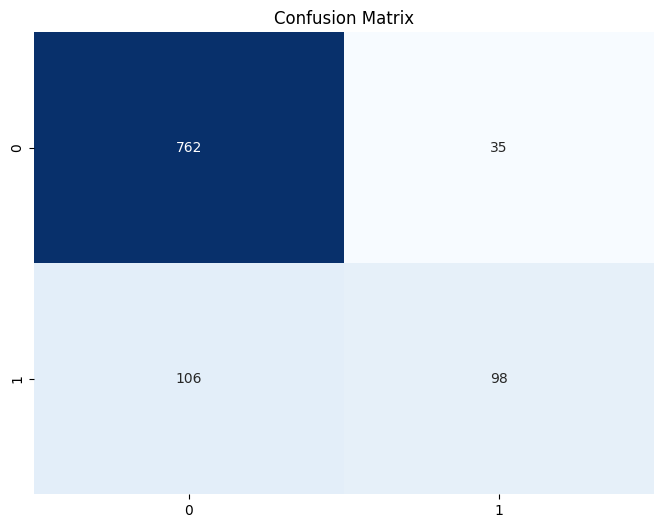

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

confusion_matrix = metrics.get('confusionMatrix')
   
cm = np.array(confusion_matrix['rows'])
cm = cm[:-1,:-1] # remove dropped

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

While it's evident that the model has a significant number of false negatives, the focus of this notebook is not on optimizing model performance but rather on exploring and understanding the available tools. Therefore, I will not be delving into the quality of the model in this instance.

# Endpoint and Deployment

In [55]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{DATANAME}_endpoint'
)

Creating Endpoint
Create Endpoint backing LRO: projects/852126792524/locations/us-central1/endpoints/8713055705055100928/operations/814085178073808896
Endpoint created. Resource name: projects/852126792524/locations/us-central1/endpoints/8713055705055100928
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/852126792524/locations/us-central1/endpoints/8713055705055100928')


In [75]:
# If the model already exists and you are re-running this notebook, load the model evaluations here:
model_resource_name = 'projects/852126792524/locations/us-central1/models/7198257435956477952'  # fill up the model's resource id
model = aiplatform.Model(model_resource_name)

Deploy the model (this process may take some time, so please be patient):

In [76]:
deployed_model = endpoint.deploy(
    model=model,
    deployed_model_display_name=f'{DATANAME}_model',
    traffic_percentage=100,
    machine_type=DEPLOY_COMPUTE,
    min_replica_count=1,
    max_replica_count=1
)

Deploying Model projects/852126792524/locations/us-central1/models/7198257435956477952 to Endpoint : projects/852126792524/locations/us-central1/endpoints/8713055705055100928
Deploy Endpoint model backing LRO: projects/852126792524/locations/us-central1/endpoints/8713055705055100928/operations/8239958013654335488
Endpoint model deployed. Resource name: projects/852126792524/locations/us-central1/endpoints/8713055705055100928


# Prediction

In [100]:
query = f"""
(
  SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped 
  WHERE split='TEST' AND Exited=1 
  LIMIT 3
)
UNION ALL
(
  SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped 
  WHERE split='TEST' AND Exited=0 
  LIMIT 3
)
"""

pred = bq.query(query=query).to_dataframe()
pred

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction_Score,Card_Type,Point_Earned,split
0,9708,15687431,Faria,642,France,Female,41,7,115171.71,1,1,1,37674.47,0,0,2,GOLD,915,TEST
1,9778,15777743,Cattaneo,705,France,Female,39,3,92224.56,1,1,1,54517.25,0,0,2,GOLD,453,TEST
2,9862,15798341,Victor,544,France,Male,38,8,0.00,1,1,1,98208.62,0,0,3,GOLD,661,TEST
3,9338,15797751,Pai,466,Germany,Female,47,5,102085.72,1,1,1,183536.24,1,1,2,GOLD,692,TEST
4,9810,15763907,Watts,820,France,Female,39,1,104614.29,1,1,0,61538.43,1,1,4,GOLD,943,TEST
5,9211,15792650,Watts,382,Spain,Male,36,0,0.00,1,1,1,179540.73,1,1,4,GOLD,659,TEST


Predict a single entry. First, remove unnecessary columns and convert all fields to strings:

In [134]:
newob = pred[pred.columns[~pred.columns.isin(TO_OMIT + [VAR_TARGET, 'split'])]].to_dict(orient='records')[0]
newob

{'CreditScore': 642,
 'Geography': 'France',
 'Gender': 'Female',
 'Age': 41,
 'Tenure': 7,
 'Balance': 115171.71,
 'NumOfProducts': 1,
 'HasCrCard': 1,
 'IsActiveMember': 1,
 'EstimatedSalary': 37674.47,
 'Satisfaction_Score': 2,
 'Card_Type': 'GOLD',
 'Point_Earned': 915}

First, we need to convert the categorical fields into strings as AutoML did:

In [132]:
def convert_for_prediction(entry):
    fields_to_convert = [
        'CreditScore', 'Age', 'Tenure', 'NumOfProducts',
        'HasCrCard', 'IsActiveMember', 'Satisfaction_Score', 'Point_Earned'
    ]
    
    for field in fields_to_convert:
        entry[field] = str(entry[field])
    
    return entry

In [135]:
newob = convert_for_prediction(newob)
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

In [136]:
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.8401569128036499, 0.1598430871963501]}], deployed_model_id='4160561895109033984', metadata=None, model_version_id='1', model_resource_name='projects/852126792524/locations/us-central1/models/7198257435956477952', explanations=None)

In [128]:
pred_class = prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]
print(f'predicted class: {pred_class}')

predicted class: 0


# Explainability

In [137]:
explanation = endpoint.explain(instances=instances, parameters=parameters)

In [139]:
explanation.predictions

[{'classes': ['0', '1'], 'scores': [0.8401569128036499, 0.1598430871963501]}]

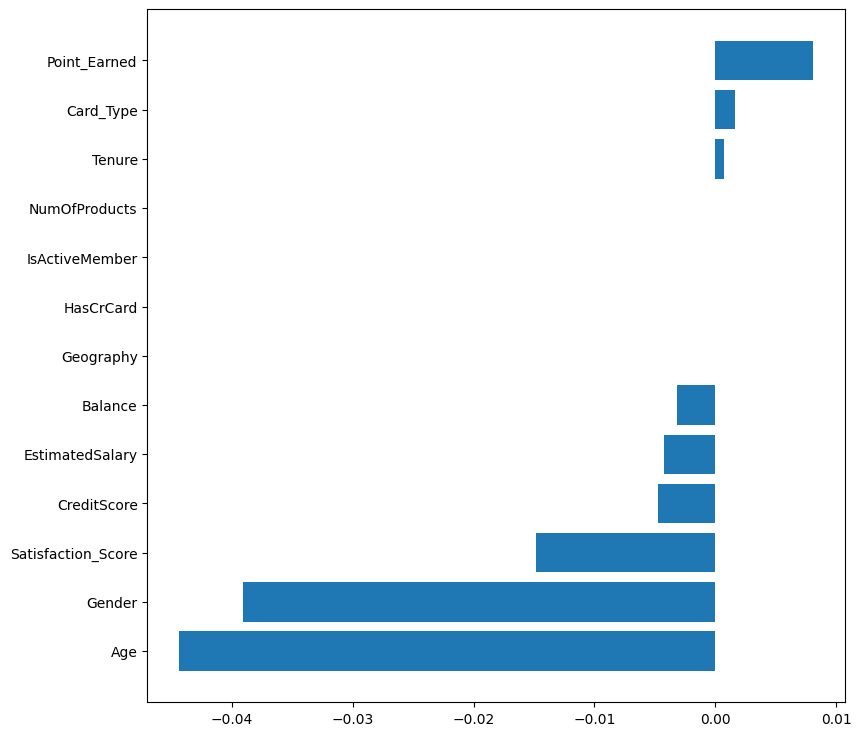

In [143]:
import matplotlib.pyplot as plt
features = []
scores = []

# Extract features and scores from the explanation object
attributions = explanation.explanations[0].attributions[0].feature_attributions

features = list(attributions.keys())
scores = list(attributions.values())
sorted_pairs = sorted(zip(scores, features))
scores, features = zip(*sorted_pairs)

fig, ax = plt.subplots(figsize=(9, 9))
ax.barh(features, scores)
fig.show()